# BUILDING MODEL

This notebook, elaborated by Jordi Vendrell, contains the study of the model of a building where the TABAS Spectra is applied to it.

## Task 2

- **Objective**: 
  - Making a story building model in Opensees.
  - Running one of the NGAWest2 ground motions (one component) to generate a response spectrum (_TABAS Spectra_)
  
- **Reference**:

  - Sections 1 and 3 from the book **Earthquake Dynamics of Structures** from the **Eartquake Engineering Research Institute EERI.**

## Theoretical background

...


## Simulation process

### Required modules
Here there is the import of all required modules in this code. 

In [1]:
import openseespy.opensees as ops  # Opensees
import os  # to read files
import math
import numpy as np  #  multidimensional array and matrix data structures
import matplotlib.pyplot as plt  # to plot the data
import opsvis as opsv
import time as t
from tqdm import tqdm

### Tabas data extraction from NGA-West2

Here there is the explanation and code lines on how to extract the file data necessary to elaborate the RotD50 Response spectra of Tabas Earthquake.

From the Earthquake data (the flatfiles) it is known that the Tabas Eartquake in Iran recorded at 1978 at Tabas Station is the Record Sequence number 143 (RSN). With this number it is possible to extract the Ground Motion Data of this Earthquake.

9 different files are obtained. For each direction (horizontal and transversal in x-y plane, and vertical) can be obtained the data from acceleration, displacement and velocity.

In this code only the x (horizontal) and y (transversal) axis directions are of interest. Because with these two directions and their respective Ground Motion Data, and with $\theta$ angle, the important Ground Motion input can be obtained.

<img src="./img/2dim.png" alt="2dim" width="350" style="float: left;"/>

And with this the RotD50 Response Spectra can be ploted. 

<img src="./img/rotd50.png" alt="rotd50" width="350" style="float: left;"/>

#### _Explore ground motion data_

In [2]:
#Define the path of the NGA-West2 files used
GMD_longitudinal = './nga_west2_db/tabas_RSN_143/RSN143_TABAS_TAB-L1.AT2'
GMD_transverse = './nga_west2_db/tabas_RSN_143/RSN143_TABAS_TAB-T1.AT2'

In [3]:
#Read the Ground Motion Data in the NGA-West2 files used
def read_NGAWest2_files(filepath):  
    """
    Read the NGAWest2 file
    
    Parameters
    ------------
    filepath : string
        location of the file
        
    Returns
    -------
    float
        dT diferential of time
    int
        number of point
    np.array
        list of ground motion acceleration
    """
    with open (filepath, "r") as GMfile:
        #put all the lines into a list
        data = GMfile.read().splitlines()
        
        #pick information from line 4 (there is the number of points and the df time differential)
        sp = data[3].split(' ')
        numPts = int(sp[3].split(',')[0])
        dt = float(sp[7])
        
        #remove headlines
        headlines = 4
        data = data[headlines:len(data)]
        
        #put acceleration data into list
        data = list(map(str.strip, data))
        data = list(map(str.split, data))
        gm = []
        for i in range(len(data)):
            for ind in range(len(data[i])):
                gm.append(float(data[i][ind]))
        
        return dt, numPts, np.array(gm)
            


In [4]:
dt1, numPts1, gmdata1 = read_NGAWest2_files(GMD_longitudinal)
dt2, numPts2, gmdata2 = read_NGAWest2_files(GMD_transverse)

In [5]:
time1 = np.linspace(0.0, numPts1*dt1, numPts1, endpoint=True)
time2 = np.linspace(0.0, numPts2*dt2, numPts2, endpoint=True)

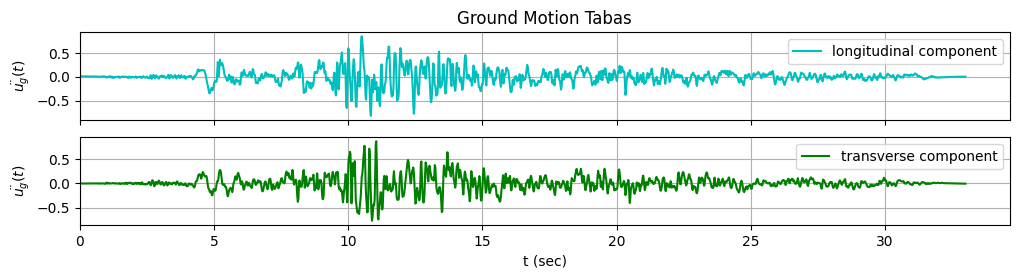

In [6]:
plt.figure(figsize=(12,2.5)) #select the visualization size of the plot
ax1=plt.subplot(211)
plt.setp(ax1.get_xticklabels(),visible=False)
plt.plot(time1, gmdata1, color='c', label='longitudinal component')
plt.ylabel('$\ddot{u_g} (t)$')
plt.title('Ground Motion Tabas')
plt.grid()
plt.xlim(left=0)
plt.legend()

plt.subplot(212,sharex=ax1)
plt.plot(time2, gmdata2, color='g', label='transverse component')
plt.ylabel('$\ddot{u_g} (t)$')
plt.xlabel('t (sec)')
plt.grid()
plt.xlim(left=0)
plt.legend()
plt.show()

#### _Find the combinational direction of Horitzontal Ground Motion + Transversal Ground Motion_

In [7]:
def create_aROT(aX, aY, theta):
    """
    Create a_ROT
    
    Parameters
    ------------
    aX : np.array
        horizontal acceleration
    aY : np.array
        transversal acceleration
    theta : int
        angle
    
    Returns
    -------
    np.array
        list of a_ROT
    """
    a_ROT = aX*math.cos(np.deg2rad(theta)) + aY*math.sin(np.deg2rad(theta))
    return a_ROT

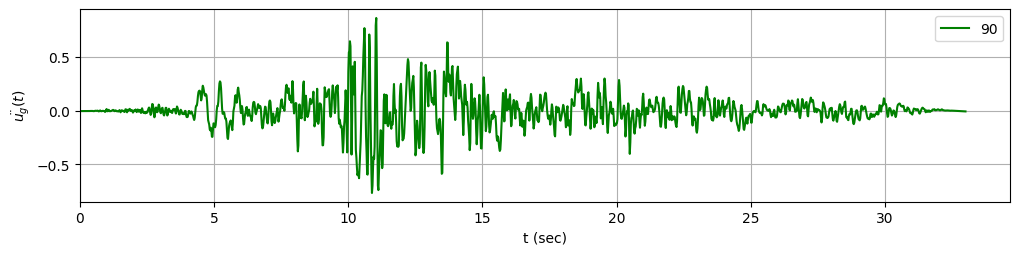

In [8]:
arot_90 = create_aROT(gmdata1, gmdata2, 90)
arot_180 = create_aROT(gmdata1, gmdata2, 180)
plt.figure(figsize=(12,2.5)) #select the visualization size of the plot
plt.plot(time2, arot_90, color='g', label='90')
#plt.plot(time2, arot_180, color='g', label='180')
plt.ylabel('$\ddot{u_g} (t)$')
plt.xlabel('t (sec)')
plt.grid()
plt.xlim(left=0)
plt.legend()
plt.show()

In [9]:
#Create Rotation Angle Array
d_theta = 1
initial_v = 0
final_v = 180 #degrees
N = (final_v - initial_v) / d_theta
theta_list = np.linspace(initial_v, final_v, num = int(N+1), endpoint=True)

### _Define the system and solve it_

<img src="./img/nodes_2.png" alt="2dim" width="350" style="float: left;"/>

<img src="./img/coord_syst.png" alt="2dim" width="350" style="float: left;"/>

<img src="./img/columns.png" alt="2dim" width="350" style="float: left;"/>

<img src="./img/x_beams.png" alt="2dim" width="350" style="float: left;"/>

<img src="./img/y_beams.png" alt="2dim" width="350" style="float: left;"/>

In [10]:
# Model definition
g = 386.1 # gravity [in/s^2]

def model_definition(mass, damping, nmodes=3):
    """
    Configure the model in opensees
    
    Parameters
    ------------
    mass : float
        mass to put at each story of the building
    damping : float
        damping
    nmodes : int
        number of mode shapes
    Returns
    --------
    float
        natural period of the structure (T [sec])
    """
    # Model parameters:
    m = mass
    
    # Model
    ops.model('basic', '-ndm', 3, '-ndf', 6)
            
    # ----------------------------------------- Create nodes ---------------------------------------------------------------
    ## Create nodes, define mass and define constraints
    
    ## Building parameters:
    storyHeight = 144 # Story Height [in] 144 inches = 12 ft
    numberOfStories = 10
    bayWidthX = 3*storyHeight
    bayWidthY = 1*storyHeight
    numberOfBaysX = 1
    numberOfBaysY = 1
    
    coordZ = 0.0
    nodeTag = 1
    for story in range(0, numberOfStories + 1):
        coordX = 0.0 
        for bayX in range(0, numberOfBaysX + 1):
            coordY = 0.0
            for bayY in range(0, numberOfBaysY + 1):
                ops.node(nodeTag, coordX, coordY, coordZ)
                ops.mass(nodeTag, m, m, 0.0, 0.0, 0.0, 0.0)
                if story == 0:
                    ops.fix(nodeTag, 1, 1, 1, 1, 1, 1)

                coordY += bayWidthY
                nodeTag += 1

            coordX += bayWidthX

        coordZ += storyHeight
        
    # --------------------------------------  Create column elements -------------------------------------------------------
    ## Elastic beam column command: ops.element('elasticBeamColumn', elementTag, node_i, node_j, A,E,G,J,Iyy,Izz,geomTransfTag)
    
    ## Element parameters:
    A_column = 50.0 # Area
    E_column = 29500.0 # Elastic Modulus
    G_column = 1000.0 # Shear Modulus
    J_column = 1000.0 # Polar Moment of Inertia
    Iyy_column = 2150.0 # Moment of Inertia in yy axis
    Izz_column = 2150.0 # Moment of Inertia in zz axis
    
    ## Transformation:
    geomTransfTagColumns = 1
    ops.geomTransf('Linear', geomTransfTagColumns, 1, 0, 0)
    
    ## Build elements:
    elementTag = 1
    nodeTag_i = 1
    for story in range(0, numberOfStories):
        for bayX in range(0, numberOfBaysX + 1):
            for bayY in range(0, numberOfBaysY + 1):
                nodeTag_j = nodeTag_i + (numberOfBaysX+1)*(numberOfBaysY+1)
                ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_column, E_column, G_column, J_column, Iyy_column, Izz_column, geomTransfTagColumns)
                elementTag += 1
                nodeTag_i += 1

    # --------------------------------------  Create beam elements X parallel -----------------------------------------------         
    
    ## Element parameters:
    A_beam_x = 50.0
    E_beam_x = 29500.0
    G_beam_x = 1000.0
    J_beam_x = 1000.0
    Iyy_beam_x = 2150.0
    Izz_beam_x = 2150.0
    
    ## Transformation:
    geomTransfTagXBeams = 2
    ops.geomTransf('Linear', geomTransfTagXBeams, 0, 0, 1)

    ## Build elements:
    numberOfNodesPerStory = (numberOfBaysX+1)*(numberOfBaysY+1)
    nodeTag_i = 1 + numberOfNodesPerStory # 1st node story 1
    for story in range(1, numberOfStories + 1):
        for bayX in range(0, numberOfBaysX):
            for bayY in range(0, numberOfBaysY + 1):
                nodeTag_j = nodeTag_i + (numberOfBaysY+1)
                ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_beam_x, E_beam_x, G_beam_x, J_beam_x, Iyy_beam_x, Izz_beam_x, geomTransfTagXBeams)
                ops.rigidLink('beam', nodeTag_i, nodeTag_j)
                elementTag += 1
                nodeTag_i += 1
        
        nodeTag_i += (numberOfBaysY+1)

    # --------------------------------------  Create beam elements Y parallel -----------------------------------------------
    
    ## Element parameters:
    A_beam_y = 50.0
    E_beam_y = 29500.0
    G_beam_y = 1000.0
    J_beam_y = 1000.0
    Iyy_beam_y = 2150.0
    Izz_beam_y = 2150.0
    
    ## Transformation:
    geomTransfTagYBeams = 3
    ops.geomTransf('Linear', geomTransfTagYBeams, 0, 0, 1)
    
    ## Build elements:
    numberOfNodesPerStory = (numberOfBaysX+1)*(numberOfBaysY+1)
    nodeTag_i = 1 + numberOfNodesPerStory # 1st node story 1
    for story in range(1, numberOfStories + 1):
        for bayX in range(0, numberOfBaysX+1):
            for bayY in range(0, numberOfBaysY):
                nodeTag_j = nodeTag_i + 1
                ops.element('elasticBeamColumn', elementTag, nodeTag_i, nodeTag_j, A_beam_y, E_beam_y, G_beam_y, J_beam_y, Iyy_beam_y, Izz_beam_y, geomTransfTagYBeams)
                ops.rigidLink('beam', nodeTag_i, nodeTag_j)
                elementTag += 1
                nodeTag_i += 1
            nodeTag_i += 1 
    
    # Define material
    #ops.uniaxialMaterial('Elastic', 11, K)
      
    # ---------------------------------------- Define Rayleigh damping ------------------------------------------------------
    eigenVals = ops.eigen('-fullGenLapack',nmodes)
    omega = math.sqrt(eigenVals[0]) # frequency
    alpha_m = 2*damping*omega
    ops.rayleigh(alpha_m, 0, 0, 0)
    
    period = 2*math.pi/omega
    return period

WARNING - the 'fullGenLapack' eigen solver is VERY SLOW. Consider using the default eigen solver.

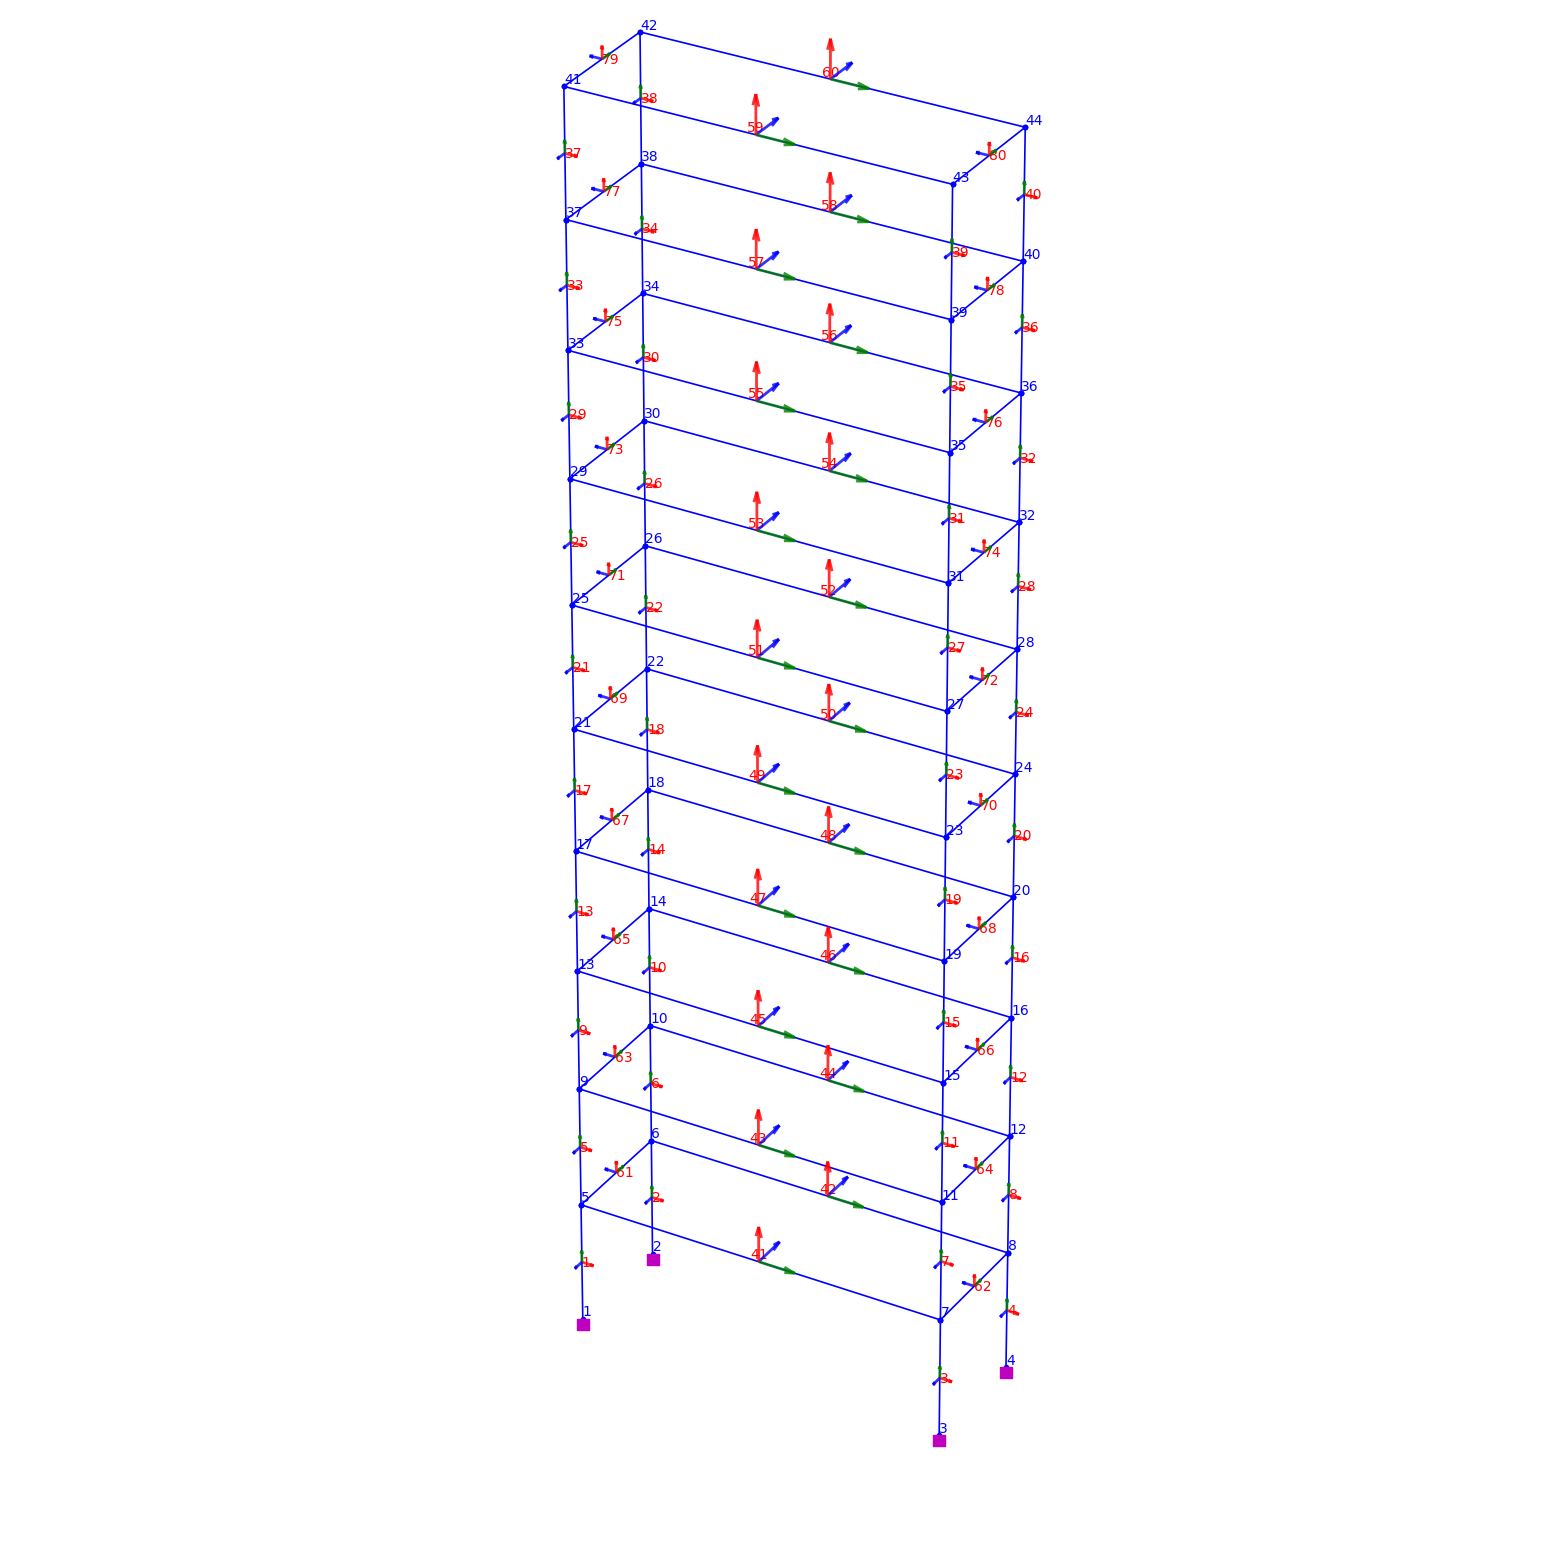

In [11]:
# Plot geometry to check that it is correct
ops.wipe()
period = model_definition(1, 0.05)
opsv.plot_model(element_labels=1,fig_wi_he=(50.0, 100.0),axis_off=1)
ops.wipe()

In [12]:
node_top=43

In [13]:
# Calculate structure natural period
print("period: ", period)

period:  4.163077578645413


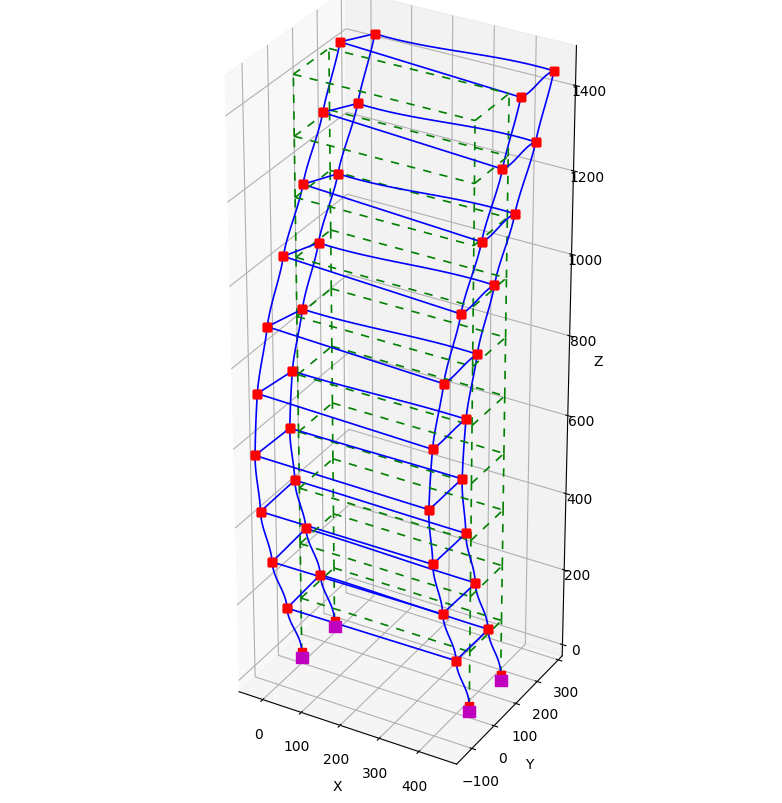

In [14]:
# Plot mode shape
ops.wipe()
model_definition(1, 0.05)
eigenVals = ops.eigen(3)
opsv.plot_mode_shape(3,fig_wi_he=(25.0, 75.0),fmt_undefo={'color': 'green', 'linestyle': (0, (5, 5)), 'linewidth': 1.2, 'marker': '', 'markersize': 1})
ops.wipe()

In [15]:
# analysis definition
dt = 0.02 # is like the precision of the time series
def define_analysis(a_ROT, time):
    """
    Configure the analysis type
    
    Parameters
    ------------
    a_ROT : np.array
        array of combinational of transverse and longitudinal GM
    time : np.array
        array of time values
        
    Returns
    --------
    None
    """
    ops.timeSeries('Path', 1, '-dt', dt, '-values', *a_ROT*g, '-time', *time) 
    ops.pattern('UniformExcitation', 1, 1, '-accel', 1)
    ops.constraints('Transformation')
    ops.numberer('Plain')
    ops.system('ProfileSPD')
    ops.algorithm('Linear', False, False, True)
    ops.integrator('Newmark', 0.5, 0.25)
    ops.analysis('Transient')    

In [16]:
# Solve system
def solve_system(mass, damping, a_ROT, time, analysis_dt):
    """
    Solve the opensees system
    
    Parameters
    ------------
    mass : float
        mass to put at each story of the building
    damping : float
        damping value
    a_ROT : np.array
        array of combinational of transverse and longitudinal GM
    time : np.array
        array of time values
    analysis_dt : float
        temporal step for each iteration of the simulation
        
    Returns
    --------
    dictionary
        dictionary with 'displacement', 'velocity' and 'acceleration' keys
    float
        natural period of the structure (T [sec])
    """

    ops.wipe()
    
    # Model Definition
    period = model_definition(mass, damping)
        
    # Analysis Definition
    define_analysis(a_ROT, time)
        
    outputs = {
        'displacement':[],
        'velocity':[], 
        'acceleration':[]
    }
    
    # Solve system
    analysis_time = time[-1]
    while ops.getTime() < analysis_time:
        ops.analyze(1, analysis_dt)
        outputs['displacement'].append(ops.nodeDisp(node_top, 1))
        outputs['velocity'].append(ops.nodeVel(node_top, 1))
        outputs['acceleration'].append(ops.nodeAccel(node_top, 1))    
        
    return outputs, period

In [17]:
# Obtain ROTD50 function

def get_ROTD50(mass, damping, a_ROT, time, analysis_dt):
    """
    Obtain ROTD50
    
    Parameters
    ------------
    mass : float
        mass to put at each story of the building
    damping : float
        damping value
    a_ROT : np.array
        array of combinational of transverse and longitudinal GM
    time : np.array
        array of time values
    analysis_dt : float
        temporal step for each iteration of the simulation
        
    Returns
    --------
    float
        RotD50
    float
        natural period of the structure (T [sec])
    """
    # calculate node 2 acceleration
    results, period = solve_system(mass, damping, a_ROT, time, analysis_dt)
    acc = results['displacement']
    acc = np.array(acc)
    ROTD50 = np.median(np.abs(acc))
    return ROTD50, period

def get_ROTD100(mass, damping, a_ROT, time, analysis_dt):
    """
    Obtain ROTD100
    
    Parameters
    ------------
    mass : float
        mass to put at each story of the building
    damping : float
        damping value
    a_ROT : np.array
        array of combinational of transverse and longitudinal GM
    time : np.array
        array of time values
    analysis_dt : float
        temporal step for each iteration of the simulation
        
    Returns
    --------
    float
        RotD100
    float
        natural period of the structure (T [sec])
    """
    # calculate node 2 acceleration
    results, period = solve_system(mass, damping, a_ROT, time, analysis_dt)
    acc = results['displacement']
    acc = np.array(acc)
    ROTD100 = np.max(np.abs(acc))
    return ROTD100, period

def get_ROTD00(mass, damping, a_ROT, time, analysis_dt):
    """
    Obtain ROTD00
    
    Parameters
    ------------
    mass : float
        mass to put at each story of the building
    damping : float
        damping value
    a_ROT : np.array
        array of combinational of transverse and longitudinal GM
    time : np.array
        array of time values
    analysis_dt : float
        temporal step for each iteration of the simulation
        
    Returns
    --------
    float
        RotD00
    float
        natural period of the structure (T [sec])
    """
    # calculate node 2 acceleration
    results, period = solve_system(mass, damping, a_ROT, time, analysis_dt)
    acc = results['displacement']
    acc = np.array(acc)
    ROTD00 = np.min(np.abs(acc))
    return ROTD00, period

In [18]:
# Get ROTD50 per each rotation angle
st = t.time()

mass_values = [0.1, 0.2, 0.5]
period_values = []
damping = 0.05
time = time1
analysis_dt = dt1
period_list=[]
for ind in range(len(mass_values)):
    rotd100_list = []
    for i in range(len(theta_list)):
        a_ROT = create_aROT(gmdata1, gmdata2, theta_list[i])
        rotd100_theta, period = get_ROTD100(mass_values[ind], damping, a_ROT, time, analysis_dt)
        rotd100_list.append(rotd100_theta)
    period_values.append(period)
    
    rotd100_list = np.array(rotd100_list)
    period_list.append(rotd100_list)

et = t.time()
elapsed_time = et - st
print('Execution time: ', elapsed_time, 'seconds')

Execution time:  594.2744839191437 seconds


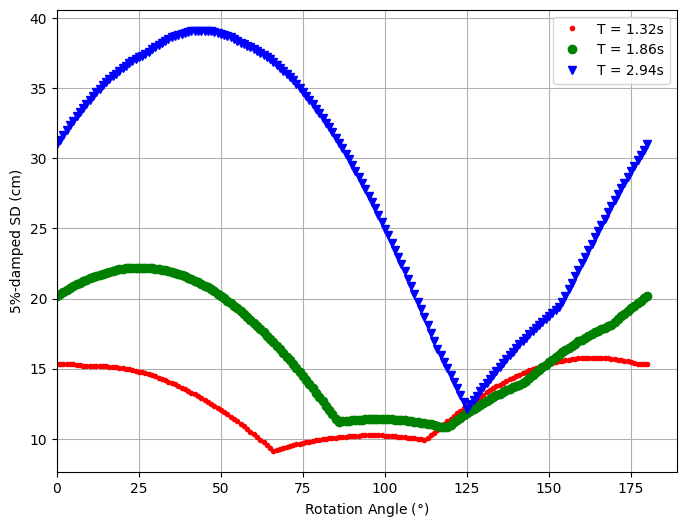

In [19]:
# 5%-damped SD (cm) vs Rotation Angle

plt.figure(figsize=(8,6)) #select the visualization size of the plot
plt.plot(theta_list, period_list[0],".",color='r', label='T = {period:.2f}s'.format(period=period_values[0]))
plt.plot(theta_list, period_list[1],"o",color='g', label='T = {period:.2f}s'.format(period=period_values[1]))
plt.plot(theta_list, period_list[2],"v",color='b', label='T = {period:.2f}s'.format(period=period_values[2]))
plt.ylabel('5%-damped SD (cm)')
plt.xlabel('Rotation Angle ($\degree$)')
plt.grid()
plt.xlim(left=0)
plt.legend()
plt.show()

In [20]:
#periods_axis = np.linspace(0.1, 10, num=50)
#angles_axis = []

#tlist=theta_list[:]
#for i in range(len(periods_axis)):
#    sd_max = -1000
#    theta_max = 0
    
#    for t in range(len(tlist)):
#        a_ROT = create_aROT(gmdata1, gmdata2, tlist[t])
#        rotd100_theta = get_ROTD100(periods_axis[i], damping, a_ROT, time, analysis_dt)
#        if np.max(rotd100_theta) > sd_max:
#            sd_max = np.max(rotd100_theta)
#            theta_max = tlist[t]

#    angles_axis.append(theta_max) 
    
#angles_axis = np.array(angles_axis)

In [21]:
#plt.figure(figsize=(8,4)) #select the visualization size of the plot
#plt.scatter(periods_axis, angles_axis)
#plt.ylabel('Rotation angle for RotD100($\degree$)')
#plt.xlabel('Period(s)')
#plt.grid()
#plt.xscale('log')
#plt.show()

In [22]:
# Get ROTD50 response spectra
st = t.time()

masses = np.linspace(0.1, 100, 500, endpoint=True) #mass
periods = []

rotd50_list = []
for i in range(len(masses)):
    a_ROT = create_aROT(gmdata1, gmdata2, theta_list[90])
    rotd50_theta = get_ROTD50(masses[i], damping, a_ROT, time, analysis_dt)
    rotd50_list.append(rotd50_theta)
    periods.append(period) # All the periods here will give the same in each for loop

rotd50_list = np.array(rotd50_list)

rotd100_list = []
for i in range(len(masses)):
    a_ROT = create_aROT(gmdata1, gmdata2, theta_list[90])
    rotd100_theta = get_ROTD100(masses[i], damping, a_ROT, time, analysis_dt)
    rotd100_list.append(rotd100_theta)

rotd100_list = np.array(rotd100_list)

rotd00_list = []
for i in range(len(masses)):
    a_ROT = create_aROT(gmdata1, gmdata2, theta_list[90])
    rotd00_theta = get_ROTD00(masses[i], damping, a_ROT, time, analysis_dt)
    rotd00_list.append(rotd00_theta)

rotd00_list = np.array(rotd00_list)

transverse_list = []
for i in range(len(masses)):
    transverse_theta = get_ROTD100(masses[i], damping, gmdata2, time, analysis_dt)
    transverse_list.append(transverse_theta)

transverse_list = np.array(transverse_list)

longitudinal_list = []
for i in range(len(masses)):
    longitudinal_theta = get_ROTD100(masses[i], damping, gmdata1, time, analysis_dt)
    longitudinal_list.append(longitudinal_theta)

longitudinal_list = np.array(longitudinal_list)

et = t.time()
elapsed_time = et - st
print('Execution time: ', elapsed_time, 'seconds')

Execution time:  2784.5487637519836 seconds


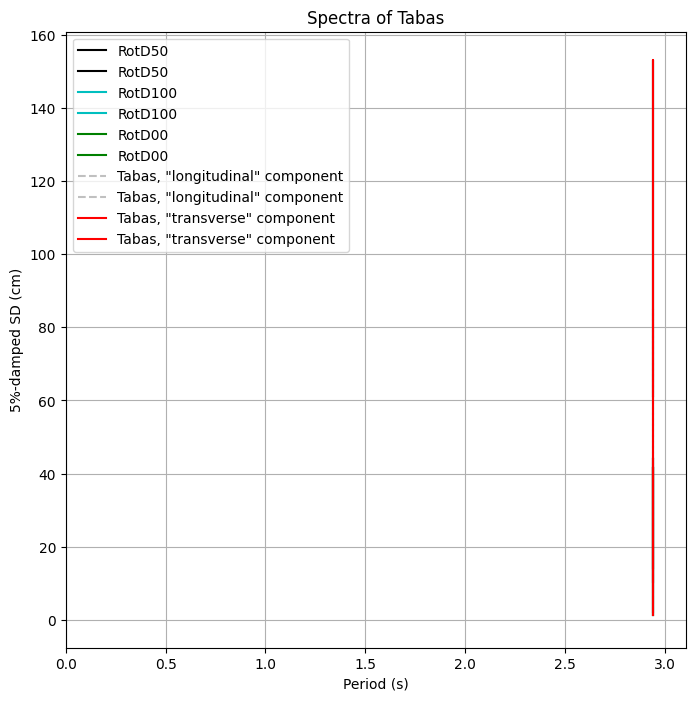

In [23]:
plt.figure(figsize=(8,8)) #select the visualization size of the plot
plt.plot(periods, rotd50_list, color='k', label='RotD50')
plt.plot(periods, rotd100_list, color='c', label='RotD100')
plt.plot(periods, rotd00_list, color='g', label='RotD00')
plt.plot(periods, longitudinal_list,"--", color='silver', label='Tabas, "longitudinal" component')
plt.plot(periods, transverse_list, color='red', label='Tabas, "transverse" component')
plt.ylabel('5%-damped SD (cm)')
plt.xlabel('Period (s)')
plt.title('Spectra of Tabas')
plt.grid()
plt.xlim(left=0)
plt.legend()
plt.show()